# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [1]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 10,      # Number of epochs.
    'n_classes': 10,      # Number of classes.
    'lr': 0.0005,         # Learning rate.
    'weight_decay': 1e-5, # L2 penalty.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 100,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'lambda_s': 1.0,      # Sparsity importance in loss computation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [3]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Random subset of training data for small data scenarios.
# torch.random.manual_seed(12345)
# indices = torch.randperm(len(train_set))[:500]
# train_set = data.Subset(train_set, indices)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
Size of training set: 60000 samples
Size of test set: 10000 samples


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# AutoEncoder Esparso

[Regularizações](https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2) são componentes comuns em vários métodos da área de Machine Learning que podem servir como um viés para que o algoritmo dê preferência a soluções mais simples, potencialmente prevenindo overfitting no caso de modelos **overcomplete** e/ou **small data**. A loss de um Sparse AE (SAE) adiciona um termo de regularização $\mathcal{L}_{s}$ à loss de regressão $\mathcal{L}_{r}$ de um AE tradicional. Dessa forma, a loss total $\mathcal{L}_{t}$ é dada por:

$\mathcal{L}_{t}(x, \hat{x}, z) = \mathcal{L}_{r}(x, \hat{x}) + \lambda_{s} \mathcal{L}_{s}(z).$

Um AE tradicional produz features com ativações consideravelmente densas dos inputs passados a ele, já que, como o objetivo principal é reconstrução, toda informação possível deve ser mantida nas representações latentes da rede.

![Dense AE](https://www.dropbox.com/s/nfiix8cfk5g9wue/Sparse_AE_1.png?dl=1)

Em contraponto, SAEs produzem representações esparsas dos dados que podem ser utilizadas para realizar [**Sparse Coding**](https://en.wikipedia.org/wiki/Sparse_dictionary_learning), o que tem várias aplicações dentro da área de Machine Learning, incluindo [melhorias na performance de algumas tarefas de classificação](https://arxiv.org/pdf/1312.5663.pdf). A imagem abaixo mostra uma rede com ativações mais esparsas devido à adição de um termo de regularização $\mathcal{L}_{s}(z)$.

![Sparse AE](https://www.dropbox.com/s/rs27590a80srntp/Sparse_AE_2.png?dl=1)

Para mais informações sobre **Sparse Coding** (e também outros tópicos interessantes de Machine Learning), um bom material pode ser encontrado nos seguintes vídeos:
*   https://www.youtube.com/watch?v=7a0_iEruGoM
*   https://www.youtube.com/watch?v=L6qhzWWtqQs

# Atividade Prática: modificando o AE Convolucional para criar representações esparsas

1.   Crie uma função que calcule o componente $\mathcal{L}_{s}(z)$, recebendo o output do encoder computado pelo AE Convolucional e aplique uma regularização L1 sobre ele: $\frac{1}{N}\sum_{i=0}^{N}{|z_{i}|}$;
2.   Utilize o fator $\lambda_{s}$ (*args\['lambda_s\']*) para criar uma loss composta $\mathcal{L}_{t}$ nas funções *train()* e *test()* com a loss de regressão $\mathcal{L}_{r}$ tradicional do AE, a qual já está implementada. A loss final $\mathcal{L}_{t}$ é que deve ser usada para computar o backward nas funções de treino e teste;
3.   Compare visualmente a densidade de ativações nos feature maps calculados no AE Convolucional denso (implementado na aula passada) e no AE Convolucional esparso.

PS.: Compute $\mathcal{L}_{s}$ usando apenas operações vetoriais, ou seja, sem o uso de um *for*, o que deixaria muito lento o algoritmo.

# Definindo a arquitetura

In [4]:
# AutoEncoder implementation.
class SparseAutoEncoder(nn.Module):
    
    def __init__(self):

        super(SparseAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.Conv2d(16, 8, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.Conv2d(8, 1, kernel_size=(3, 3), stride=1, padding=1),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec, enc

# Instantiating architecture.
net = SparseAutoEncoder().to(args['device'])

# Printing architecture.
print(net)


SparseAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)


# Definindo o otimizador

In [5]:
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'])

# Definindo a loss

In [6]:
def sparse_loss(tensor):
    return torch.mean(torch.abs(tensor))
#     return torch.sum(torch.abs(tensor))

In [7]:
criterion_reconstruction = nn.MSELoss().to(args['device'])
# criterion_reconstruction = nn.L1Loss().to(args['device'])

# Criando funções para Treino e Teste

In [8]:
# Training procedure.
def train(train_loader, net, criterion_reconstruction, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables and reshaping.
        inps = inps.to(args['device'])
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs, cods = net(inps)

        # Computing loss.
        loss_rec = criterion_reconstruction(outs, inps)
        loss_spr = args['lambda_s'] * sparse_loss(cods)
        loss = loss_rec + loss_spr

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Updating lists.
        train_loss.append((loss_rec.data.item(),
                           loss_spr.data.item(),
                           loss.data.item()))
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train rec loss %.4f +/- %.4f], [train spr loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss[:,0].mean(), train_loss[:,0].std(), train_loss[:,1].mean(), train_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

In [9]:
# Testing procedure.
def test(test_loader, net, criterion_reconstruction, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables and reshaping.
        inps = inps.to(args['device'])

        # Forwarding.
        outs, cods = net(inps)

        # Computing loss.
        loss_rec = criterion_reconstruction(outs, inps)
        loss_spr = args['lambda_s'] * sparse_loss(cods)
        loss = loss_rec + loss_spr
        
        # Updating lists.
        test_loss.append((loss_rec.data.item(),
                          loss_spr.data.item(),
                          loss.data.item()))
        
        if i == 0 and epoch % args['print_freq'] == 0:
            
            fig, ax = plt.subplots(10, 8, figsize=(16, 20))
        
        if i < 8 and epoch % args['print_freq'] == 0:
            
            ax[0, i].imshow(inps[0, 0].detach().cpu().numpy())
            ax[0, i].set_yticks([])
            ax[0, i].set_xticks([])
            ax[0, i].set_title('Image ' + str(i + 1))
            
            ax[1, i].imshow(outs[0, 0].detach().cpu().numpy())
            ax[1, i].set_yticks([])
            ax[1, i].set_xticks([])
            ax[1, i].set_title('Reconstructed ' + str(i + 1))
            
            
            for c in range(8):
                
                ax[2 + c, i].imshow(cods[0, c].detach().cpu().numpy())
                ax[2 + c, i].set_yticks([])
                ax[2 + c, i].set_xticks([])
                ax[2 + c, i].set_title('Bottleneck[' + str(c) + '] ' + str(i + 1))
            
        if i == 8 and epoch % args['print_freq'] == 0:
            
            plt.show()
    
    toc = time.time()
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test rec loss %.4f +/- %.4f], [test spr loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss[:,0].mean(), test_loss[:,0].std(), test_loss[:,1].mean(), test_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [train rec loss 0.0495 +/- 0.0425], [train spr loss 0.0081 +/- 0.0069], [training time 11.53]
-------------------------------------------------------------------


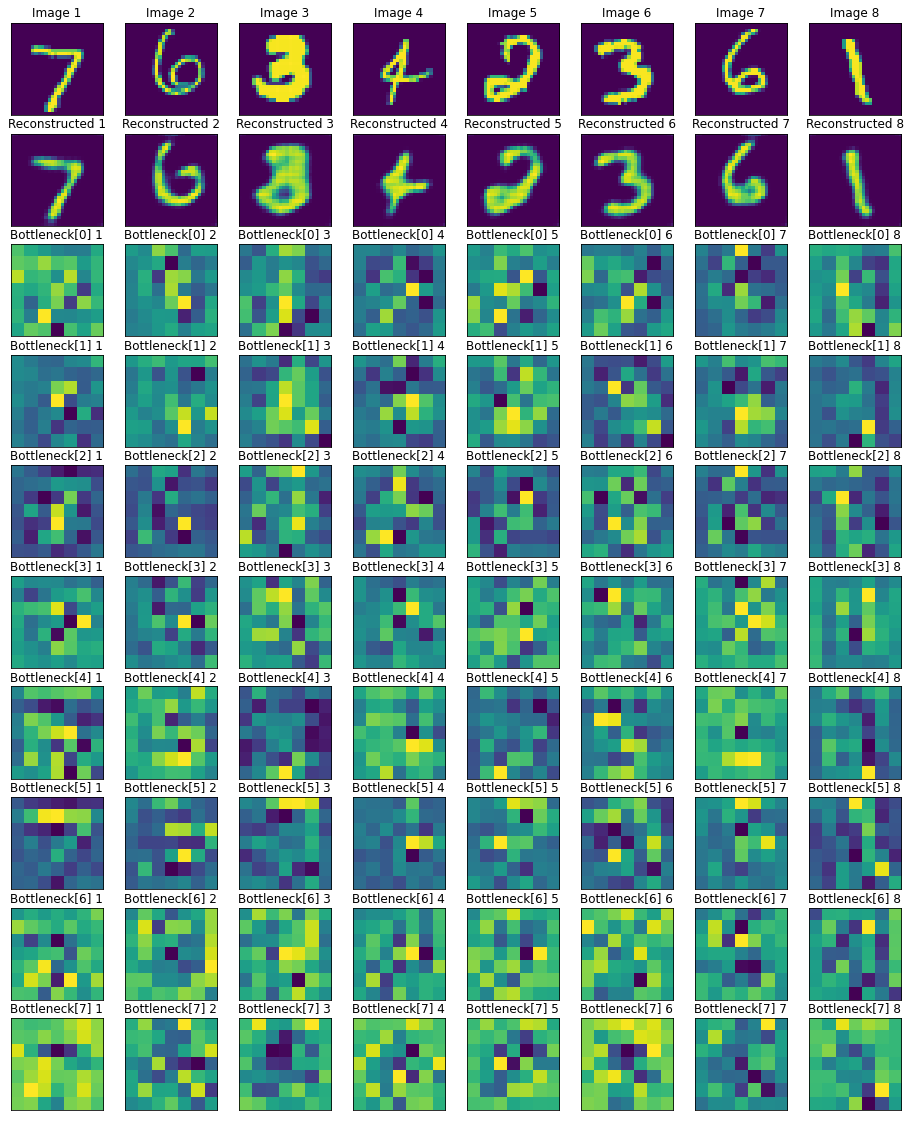

-------------------------------------------------------------------
[epoch 1], [test rec loss 0.0141 +/- 0.0008], [test spr loss 0.0042 +/- 0.0001], [testing time 3.78]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train rec loss 0.0110 +/- 0.0016], [train spr loss 0.0032 +/- 0.0005], [training time 11.00]
-------------------------------------------------------------------


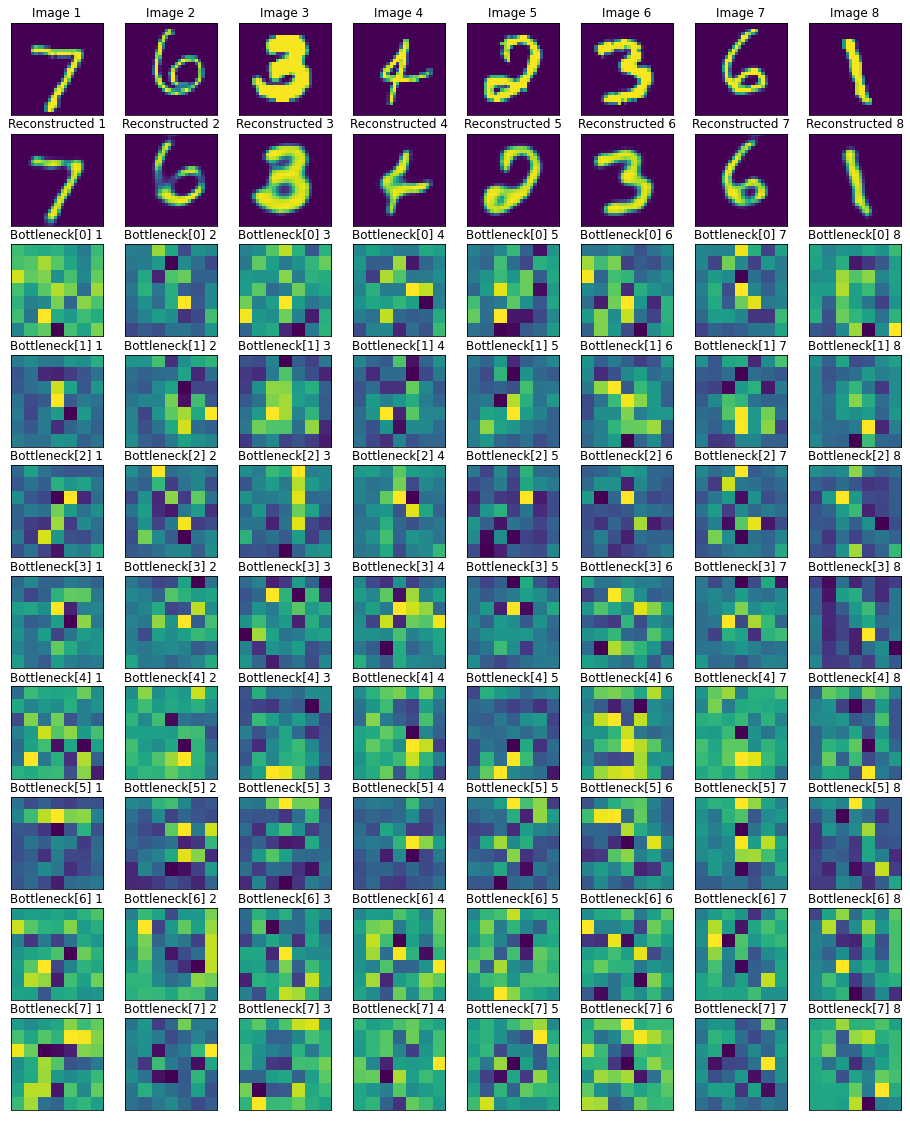

-------------------------------------------------------------------
[epoch 2], [test rec loss 0.0086 +/- 0.0007], [test spr loss 0.0024 +/- 0.0001], [testing time 3.79]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train rec loss 0.0079 +/- 0.0006], [train spr loss 0.0020 +/- 0.0002], [training time 11.67]
-------------------------------------------------------------------


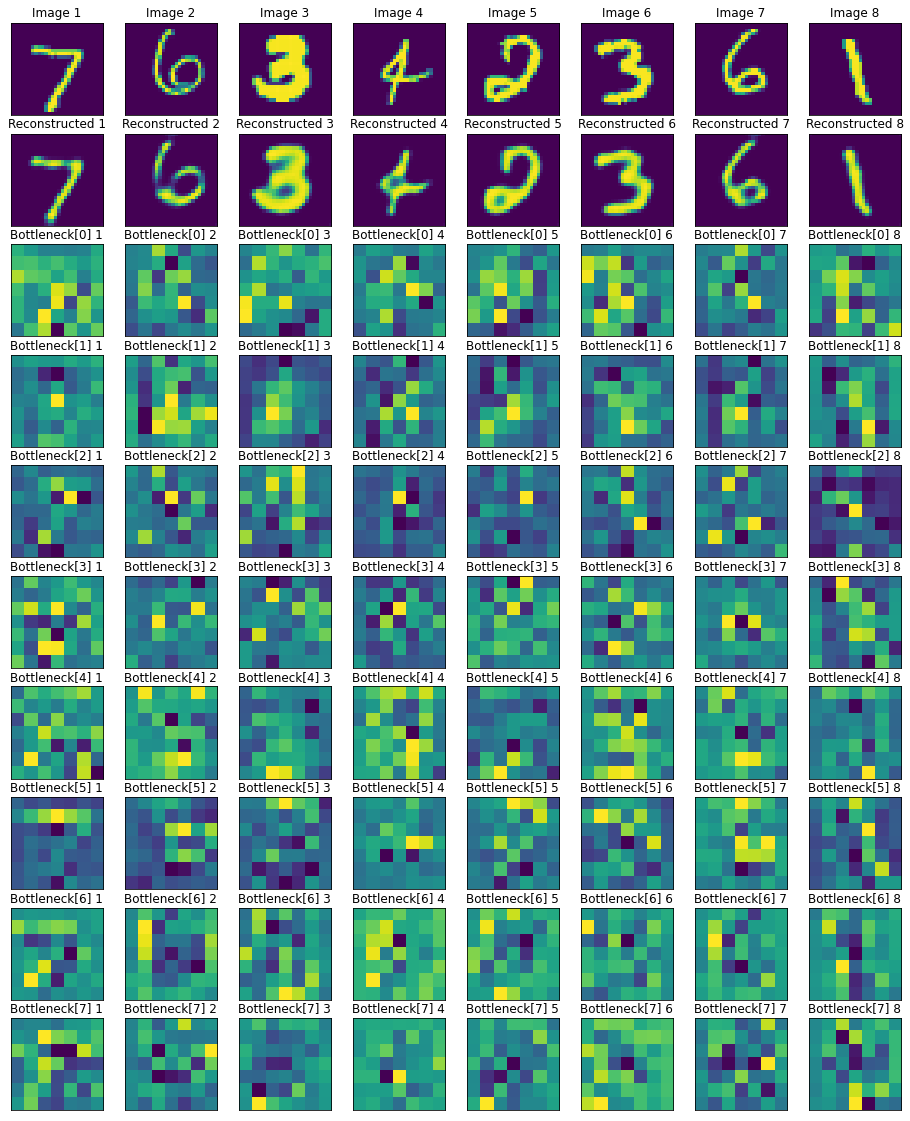

-------------------------------------------------------------------
[epoch 3], [test rec loss 0.0068 +/- 0.0006], [test spr loss 0.0017 +/- 0.0000], [testing time 3.84]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 4], [train rec loss 0.0067 +/- 0.0004], [train spr loss 0.0015 +/- 0.0001], [training time 11.29]
-------------------------------------------------------------------


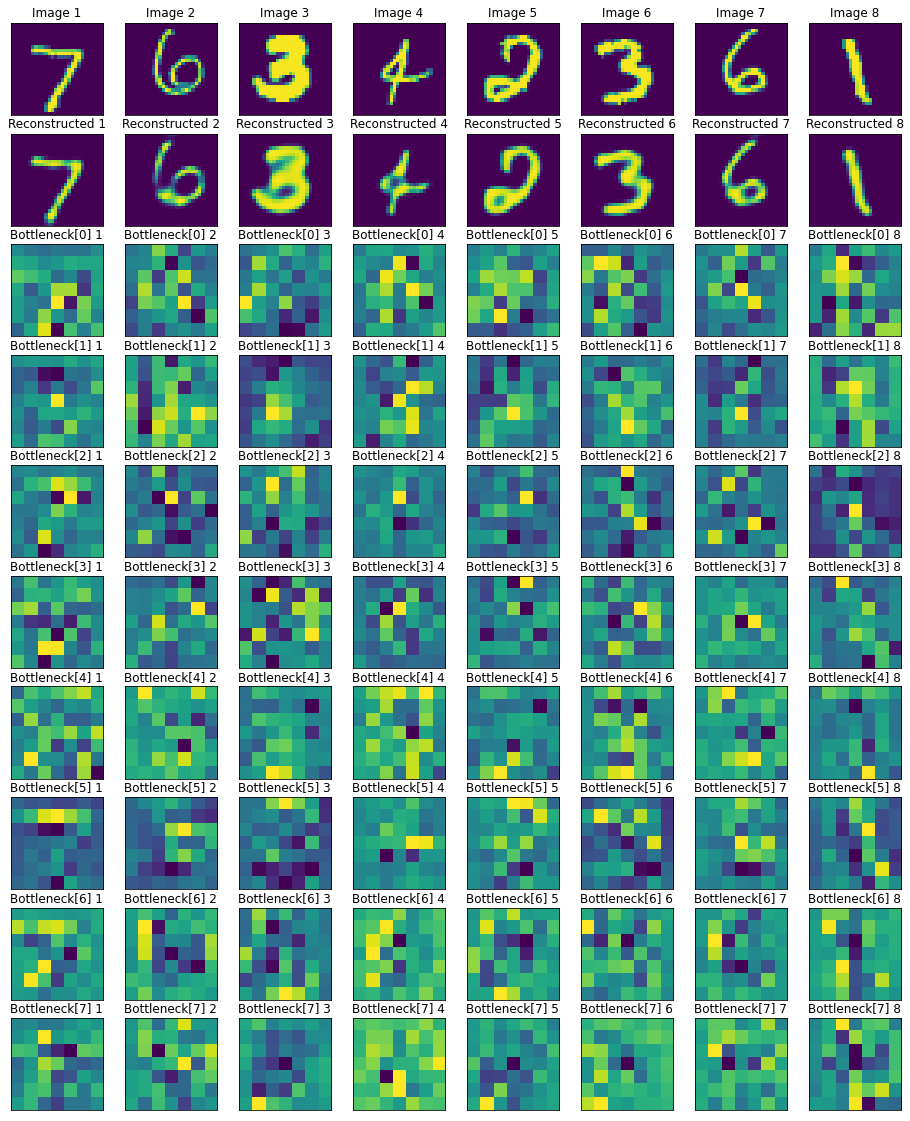

-------------------------------------------------------------------
[epoch 4], [test rec loss 0.0061 +/- 0.0005], [test spr loss 0.0013 +/- 0.0000], [testing time 3.83]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 5], [train rec loss 0.0059 +/- 0.0004], [train spr loss 0.0012 +/- 0.0001], [training time 11.89]
-------------------------------------------------------------------


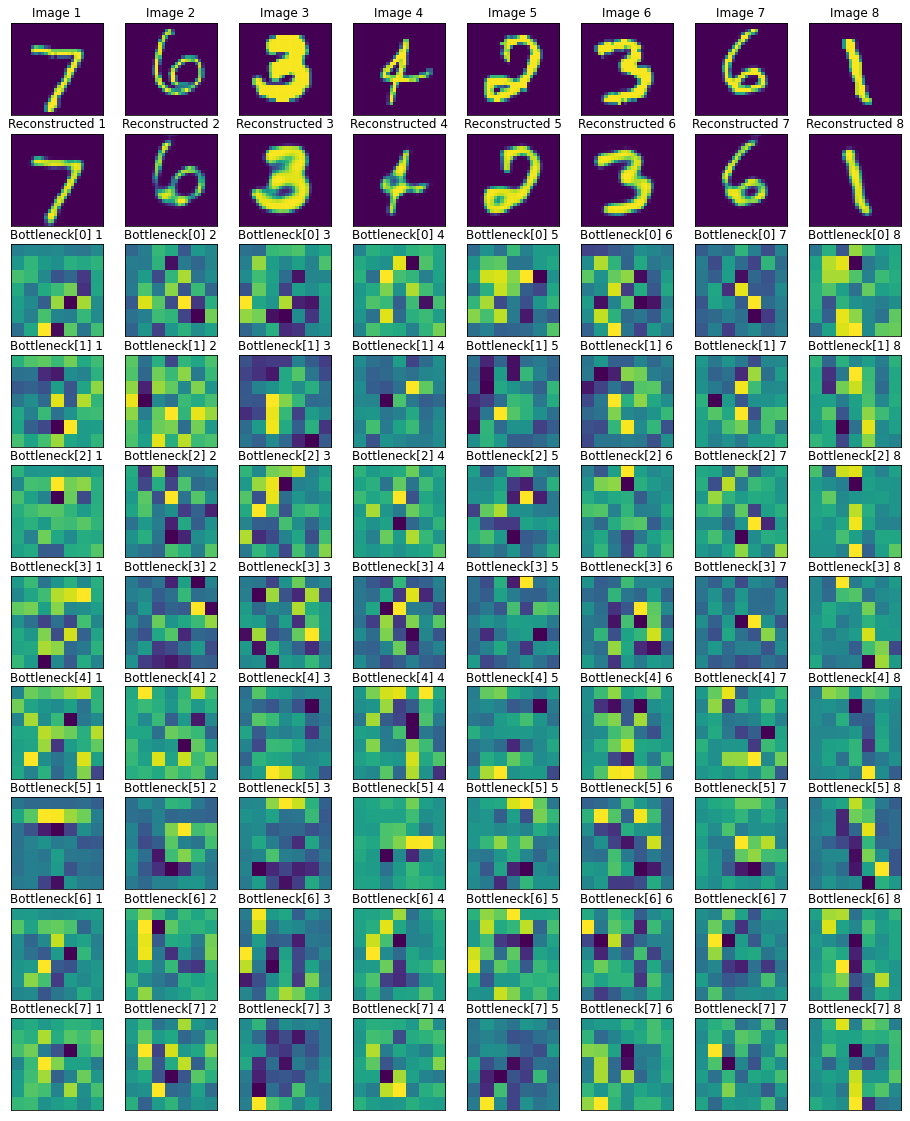

-------------------------------------------------------------------
[epoch 5], [test rec loss 0.0052 +/- 0.0005], [test spr loss 0.0011 +/- 0.0000], [testing time 3.99]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train rec loss 0.0052 +/- 0.0003], [train spr loss 0.0010 +/- 0.0000], [training time 11.66]
-------------------------------------------------------------------


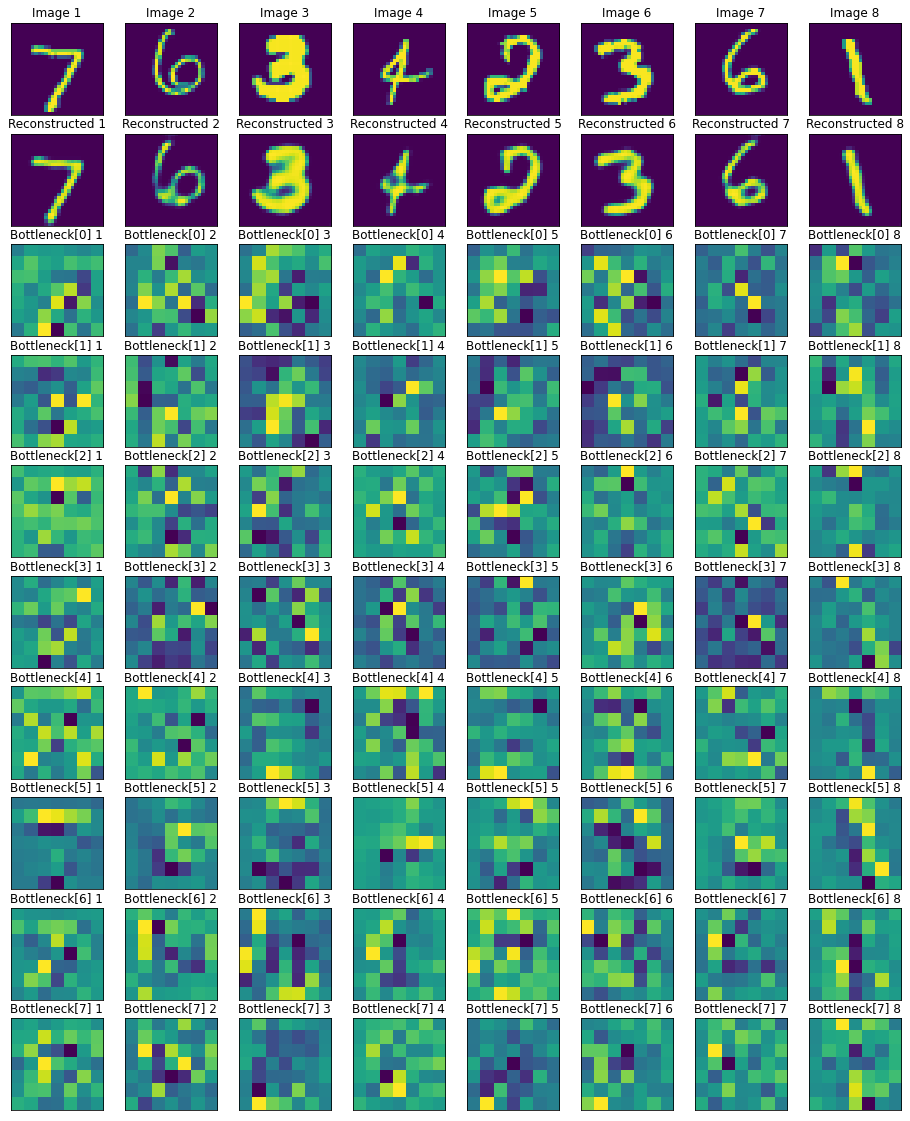

-------------------------------------------------------------------
[epoch 6], [test rec loss 0.0048 +/- 0.0005], [test spr loss 0.0010 +/- 0.0000], [testing time 3.69]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train rec loss 0.0049 +/- 0.0003], [train spr loss 0.0009 +/- 0.0000], [training time 11.65]
-------------------------------------------------------------------


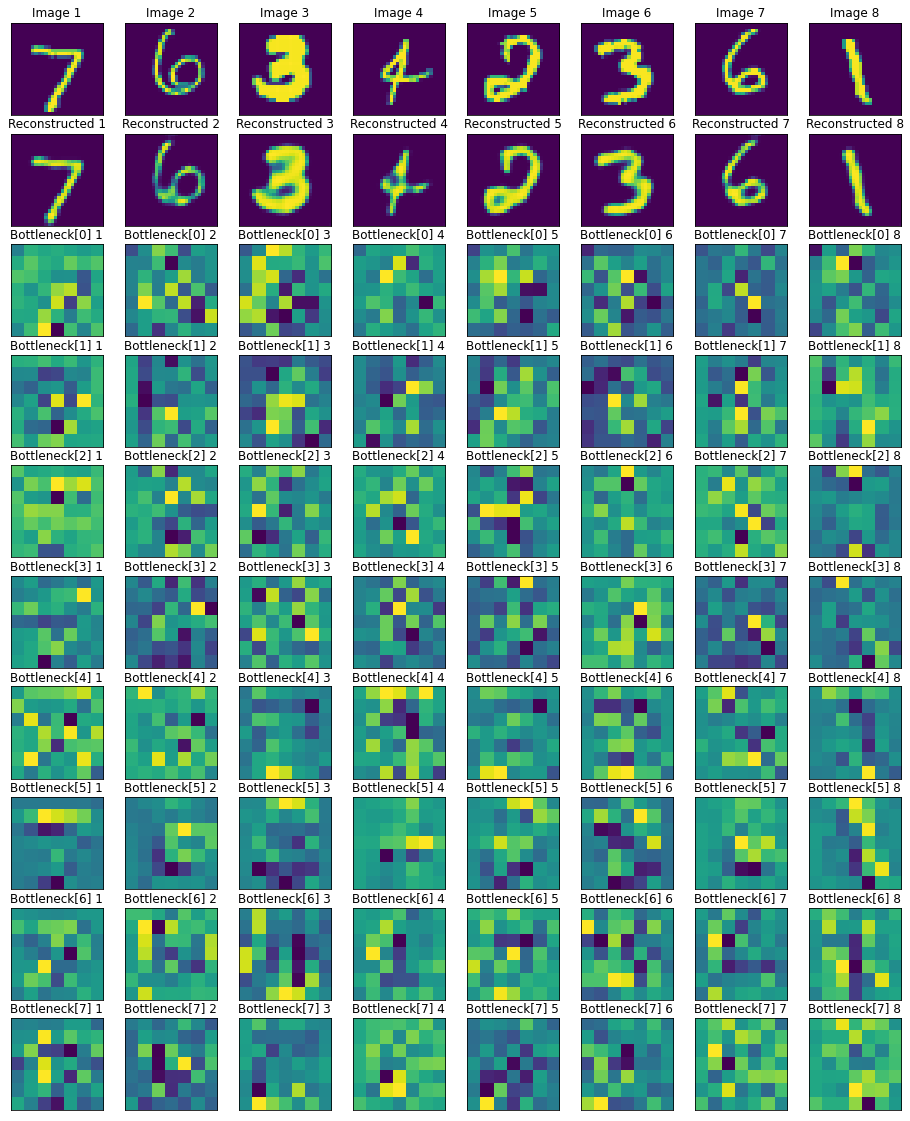

-------------------------------------------------------------------
[epoch 7], [test rec loss 0.0046 +/- 0.0004], [test spr loss 0.0009 +/- 0.0000], [testing time 3.73]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 8], [train rec loss 0.0047 +/- 0.0003], [train spr loss 0.0008 +/- 0.0000], [training time 11.00]
-------------------------------------------------------------------


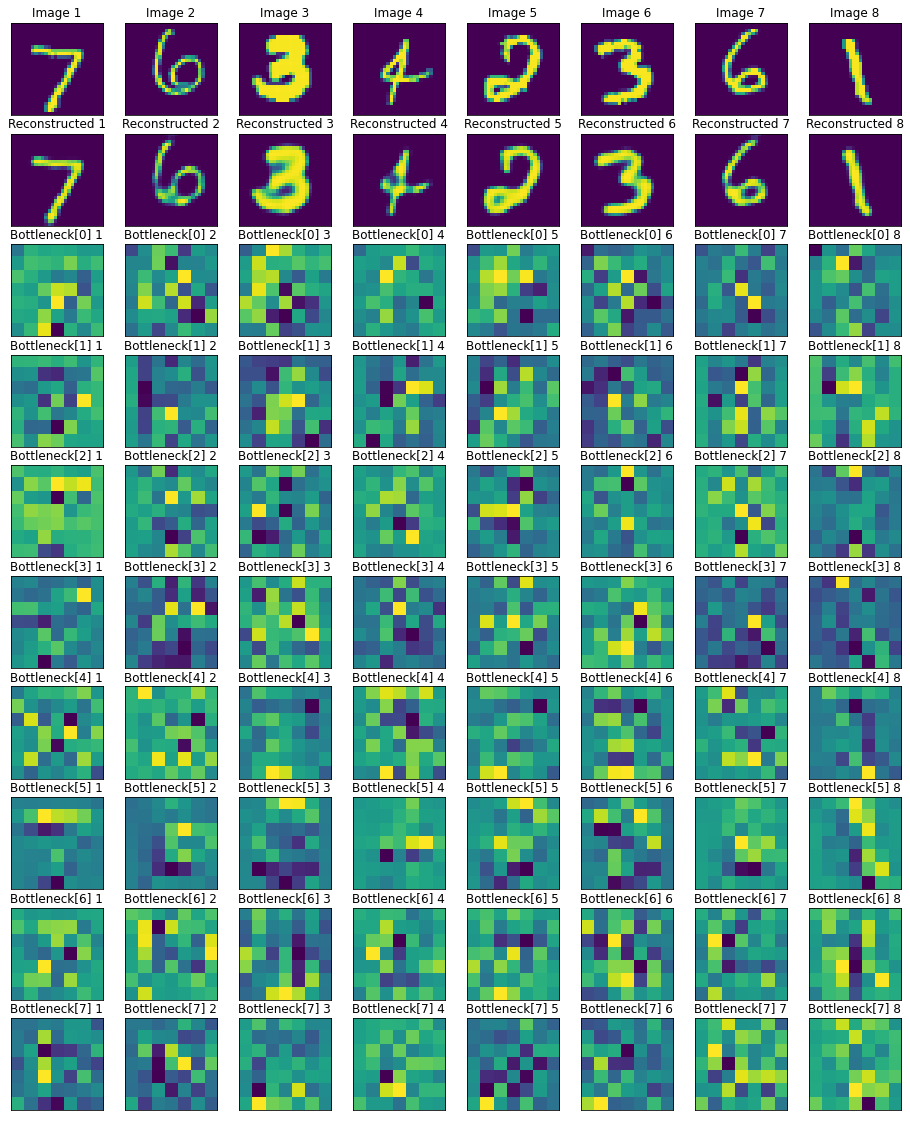

-------------------------------------------------------------------
[epoch 8], [test rec loss 0.0043 +/- 0.0004], [test spr loss 0.0008 +/- 0.0000], [testing time 3.91]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 9], [train rec loss 0.0044 +/- 0.0003], [train spr loss 0.0008 +/- 0.0000], [training time 11.42]
-------------------------------------------------------------------


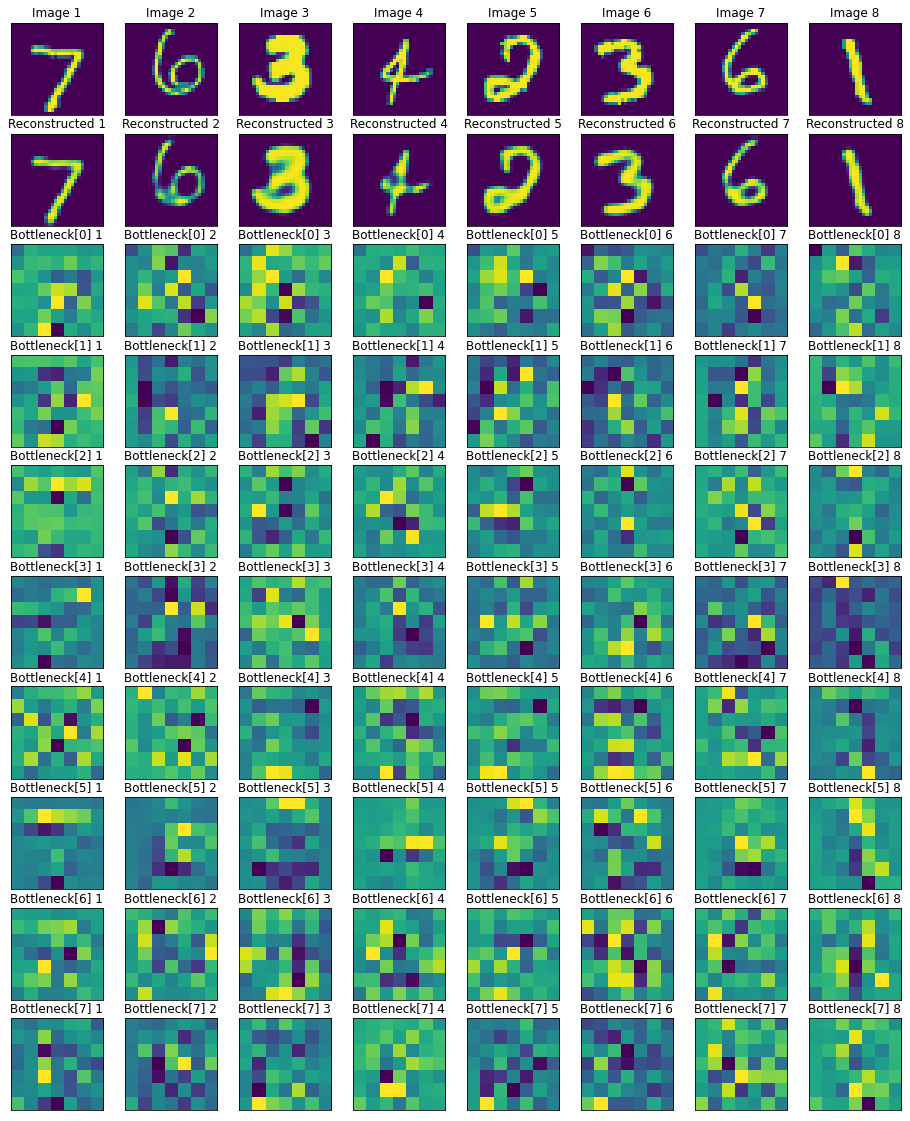

-------------------------------------------------------------------
[epoch 9], [test rec loss 0.0041 +/- 0.0004], [test spr loss 0.0007 +/- 0.0000], [testing time 3.77]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 10], [train rec loss 0.0043 +/- 0.0002], [train spr loss 0.0007 +/- 0.0000], [training time 11.70]
-------------------------------------------------------------------


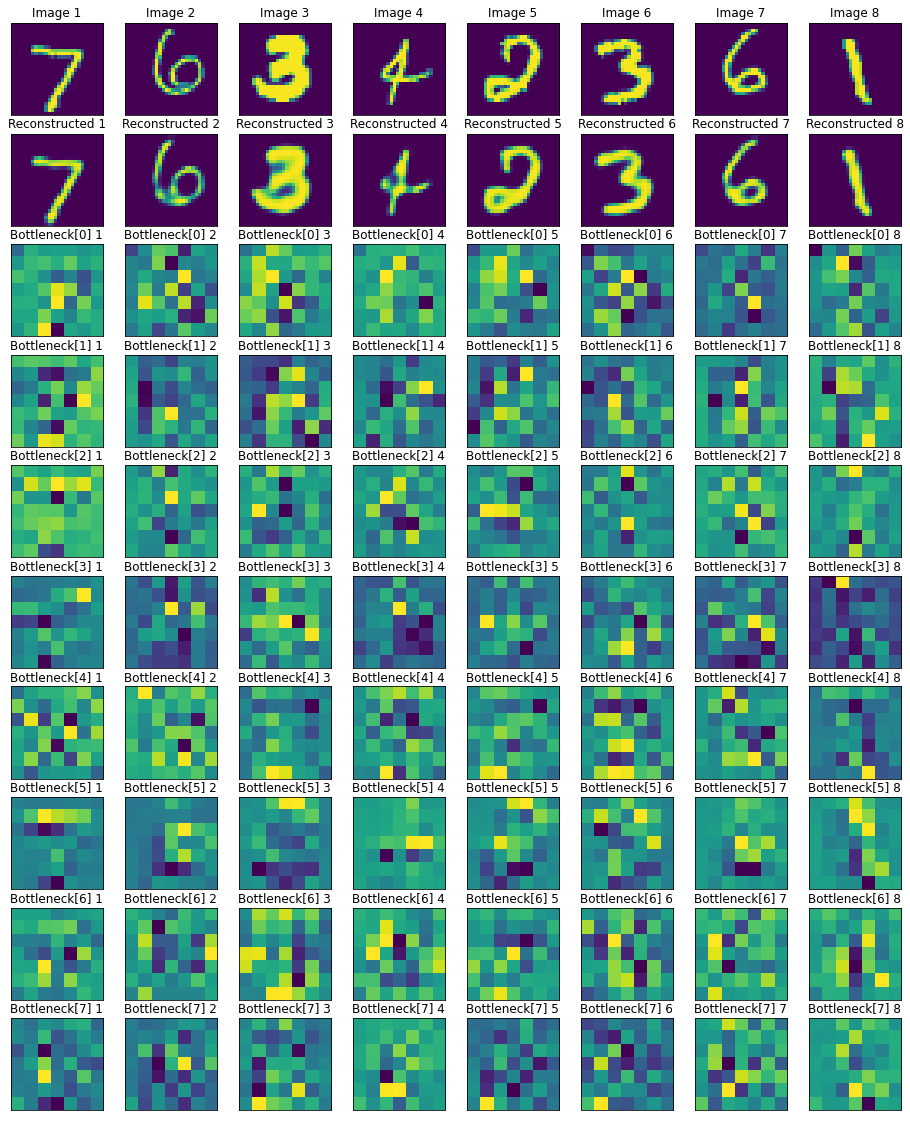

-------------------------------------------------------------------
[epoch 10], [test rec loss 0.0040 +/- 0.0004], [test spr loss 0.0007 +/- 0.0000], [testing time 3.74]
-------------------------------------------------------------------


In [10]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion_reconstruction, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, criterion_reconstruction, epoch)

# Usando a representação de bottleneck como features

In [11]:
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics

# Evaluating procedure for digit classification.
def evaluate(train_loader, test_loader, net):
    
    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for features and labels.
    train_samples = []
    train_labels = []
    
    test_samples = []
    test_labels = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
            
        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables and reshaping.
        inps = inps.to(args['device'])

        # Forwarding.
        outs, cods = net(inps)
        
        # Iterating over images in batch.
        for b in range(inps.size(0)):
            
            features = cods[b].detach().cpu().numpy().ravel()
            label = labs[b].detach().item()
            
            train_samples.append(features)
            train_labels.append(label)
            

    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables and reshaping.
        inps = inps.to(args['device'])

        # Forwarding.
        outs, cods = net(inps)
        
        # Iterating over images in batch.
        for b in range(inps.size(0)):
            
            features = cods[b].detach().cpu().numpy().ravel()
            label = labs[b].detach().item()
            
            test_samples.append(features)
            test_labels.append(label)
    
    # Transforming lists to numpy arrays.
    train_samples = np.asarray(train_samples)
    train_labels = np.asarray(train_labels)
    
    test_samples = np.asarray(test_samples)
    test_labels = np.asarray(test_labels)
    
    
    # Classifying using an RF.
    clf_rf = ensemble.RandomForestClassifier(n_estimators=50)
    clf_rf.fit(train_samples, train_labels)
    test_preds_rf = clf_rf.predict(test_samples)
    
    acc_rf = metrics.accuracy_score(test_labels, test_preds_rf)
    
    toc = time.time()
    
    # Using the features to perform classification on a supervised setting.
    print('-------------------------------------------------------------------')
    print('[rf accuracy %.4f], [time %.2f]' % (
        acc_rf, (toc - tic)))
    print('-------------------------------------------------------------------')
    
evaluate(train_loader, test_loader, net)

-------------------------------------------------------------------
[rf accuracy 0.9520], [time 163.52]
-------------------------------------------------------------------
